## Contexto
Uma empresa lançou um teste A/B para avaliar a usabilidade do menu lateral de sua plataforma. O teste compara duas configurações:
1. Acesso direto a uma página específica do site (Nível 0 do menu lateral).
2. Acesso à mesma página, mas sob uma aba mais geral (Nível 1 do menu lateral).

O objetivo do desafio a seguir é determinar qual configuração do menu lateral leva a mais acessos e conversões para a página
específica da plataforma . Identificar a configuração mais eficaz ajudará a otimizar a navegação do site para aumentar o engajamento
dos usuários.

## Base de Dados
A base de dados anexada a este desafio inclui as seguintes colunas:

`user_id` : identificador único do usuário

`device` : dispositivo do qual o usuário acessou a plataforma

`country` : país do qual o usuário acessou a plataforma

`timestamp` : data e horário em que o usuário acessou a plataforma

`group` : versão do menu lateral (Nível 0 ou Nível 1)

`converted` : conversão do usuário para a página de interesse

`session_duration` : tempo (s) em que o usuário permaneceu ativo na página de interesse

## Questões
1. Qual configuração do menu lateral levou mais usuários a acessarem a página específica?
2. Qual o tempo médio de sessão para cada configuração do menu?
3. Qual é a taxa de conversão para cada configuração do menu?
4. A diferença nos acessos entre as configurações é estatisticamente significativa?
5. Quais insights podem ser derivados dos dados para otimizar a navegação do site e aumentar o engajamento dos usuários?
6. Existe alguma tendência temporal (comportamento ao longo dia) nos acessos ou conversões para cada configuração do menu?
7. Quais recomendações você faria com base nos dados analisados para otimizar a navegação do site?

In [43]:
# importando as biblioteccas
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [59]:
# abrindo df
df = pd.read_csv(r'C:\Users\earap\OneDrive\Desktop\Dynamox\df_final.csv', encoding='utf-8')

In [45]:
# conectando ao duckdb
con = db.connect(database=':memory:')

In [46]:
# criando um df com o duckdb
con.execute("CREATE TABLE df_final AS SELECT * FROM df")

In [47]:
# selecionando o df
result = con.execute("SELECT * FROM df_final").fetchdf()
result

,user_id,device,country,timestamp,group,converted,session_duration,hour_of_day
0,42,Smartphone,França,2024-06-01 06:02:00,Nível 0,1,18.675765,6
1,1650,Tablet,Reino Unido,2024-06-01 14:41:00,Nível 0,1,4.283270,14
2,1308,Tablet,Reino Unido,2024-06-01 08:19:00,Nível 1,1,17.949853,8
3,671,Smartphone,França,2024-06-01 15:29:00,Nível 0,1,18.844162,15
4,51,Smartphone,Brasil,2024-06-01 14:30:00,Nível 0,1,4.285244,14
...,...,...,...,...,...,...,...,...
2168,1587,Desktop,Índia,2024-06-01 05:25:00,Nível 0,0,0.000000,5
2169,838,Tablet,Brasil,2024-06-01 07:14:00,Nível 1,1,2.292511,7
2170,1823,Tablet,Índia,2024-06-01 09:09:00,Nível 1,0,0.000000,9
2171,1853,Desktop,Austrália,2024-06-01 07:19:00,Nível 1,1,1.908920,7


### Questão 1
##### 1. Qual configuração do menu lateral levou mais usuários a acessarem a página específica?

In [48]:
# # consulta para determinar o total de acessos convertidos conforme cada nível
q1 = con.execute("""
    select 
        "group", 
        "converted", 
        COUNT(*) as total_acessos 
    FROM df_final
    where "converted" = 1
    group by "group", "converted"
    order by total_acessos DESC
    """).fetchdf()
q1

,group,converted,total_acessos
0,Nível 0,1,569
1,Nível 1,1,108


### Questão 1 - Resposta:

##### 1. Qual configuração do menu lateral levou mais usuários a acessarem a página específica?

 -  A configuração Nível 0 levou mais usuários a acessarem a página específica.


### Questão 2
##### 2. Qual o tempo médio de sessão para cada configuração do menu?

In [49]:
# consulta para determinar o tempo medio de cada sessao
q2 = con.execute("""
    select
        "group",
        round(avg("session_duration"),2) as tempo_medio
    from df_final
    group by "group"
    """).fetchdf()
q2

,group,tempo_medio
0,Nível 0,7.87
1,Nível 1,1.54


### Questão 2 - Resposta:
##### 2. Qual o tempo médio de sessão para cada configuração do menu?
- O tempo médio para para o Nível 0 - é 7.87 enquanto para o Nível 1 é 1.54

### Questão 3:

##### 3. Qual é a taxa de conversão para cada configuração do menu?

In [50]:
# consulta para determinar a taxa de conversao
q3 = con.execute("""
        select 
            "group",
            sum(case when converted = 1 then 1 else 0 end) AS total_convertido,
            count(*) AS total_acesso,
            cast(sum(case when converted = 1 then 1 else 0 end) as float) / count(*) AS taxa_conversao
        from df_final
        group by "group"
        order by taxa_conversao DESC
        """).fetchdf()
q3

,group,total_convertido,total_acesso,taxa_conversao
0,Nível 0,569.0,1383,0.411424
1,Nível 1,108.0,790,0.136709


### Questão 3 - Resposta:

##### 3. Qual é a taxa de conversão para cada configuração do menu?

- A taxa de conversão para o Nível O é 0.411424 e  para o Nível 1 é 0.136709.

### Questão 4:

##### 4. A diferença nos acessos entre as configurações é estatisticamente significativa?

In [51]:
q4 = con.execute("""
        select 
            "group",
            sum(case when converted = 1 then 1 else 0 end) as convertido,
            sum(case when converted = 0 then 1 else 0 end) as nao_convertido
        from df_final
        group by "group"
        """).fetchdf()
q4

,group,convertido,nao_convertido
0,Nível 0,569.0,814.0
1,Nível 1,108.0,682.0


In [52]:
tabela_contigencia = q4[['convertido','nao_convertido']].values
tabela_contigencia

array([[569., 814.],
       [108., 682.]])

In [53]:
chi2, p, dof, expected = chi2_contingency(tabela_contigencia)
print(f"Qui-quadrado: {chi2}")
print(f"P-valor: {p}")
print(f"Graus de liberdade: {dof}")
print("Frequências esperadas:")
print(expected)

Qui-quadrado: 175.63270836062398
P-valor: 4.355528155818718e-40
Graus de liberdade: 1
Frequências esperadas:
[[430.87482743 952.12517257]
 [246.12517257 543.87482743]]


In [54]:
# Interpretação dos resultados
alpha = 0.05
if p < alpha:
    print("A diferença nos acessos entre as configurações é estatisticamente significativa (p < 0.05).")
else:
    print("A diferença nos acessos entre as configurações não é estatisticamente significativa (p >= 0.05).")

A diferença nos acessos entre as configurações é estatisticamente significativa (p < 0.05).


### Questão 4 - Resposta:

##### 4. A diferença nos acessos entre as configurações é estatisticamente significativa?
Dado que o p-valor é muito menor que 0.05, rejeitamos a hipótese nula de que não há associação entre a configuração do menu (group) e a conversão (converted). Portanto, concluímos que a diferença nos acessos entre as configurações do menu lateral é estatisticamente significativa.

Essa análise sugere que a configuração do menu tem um impacto significativo nas conversões dos usuários.

### Questão 5:

##### 5. Quais insights podem ser derivados dos dados para otimizar a navegação do site e aumentar o engajamento dos usuários?

### Questão 5 - Resposta:

Podemos inferir a partir do p-valor que o menu Nível 0 é mais eficiente, portanto, podemos aprimorar essa página a fim de auentar as conversões e o engajamento dos usuários.


### Questão 6:

##### 6. Existe alguma tendência temporal (comportamento ao longo dia) nos acessos ou conversões para cada configuração do menu?



In [55]:
# Converter a coluna timestamp para datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Criar uma coluna para a hora do dia
df['hour'] = df['timestamp'].dt.hour

In [56]:
# consulta para gregar os dados para contagem de acessos e conversões por hora e grupo
q6 = con.execute("""
    select
        "hour",
        "group",
        count("user_id") as access_count,
        sum("converted") as conversions_count
    from df
        group by hour, "group"
        order by hour, "group"
    """).fetchdf()
q2

,group,tempo_medio
0,Nível 0,7.87
1,Nível 1,1.54


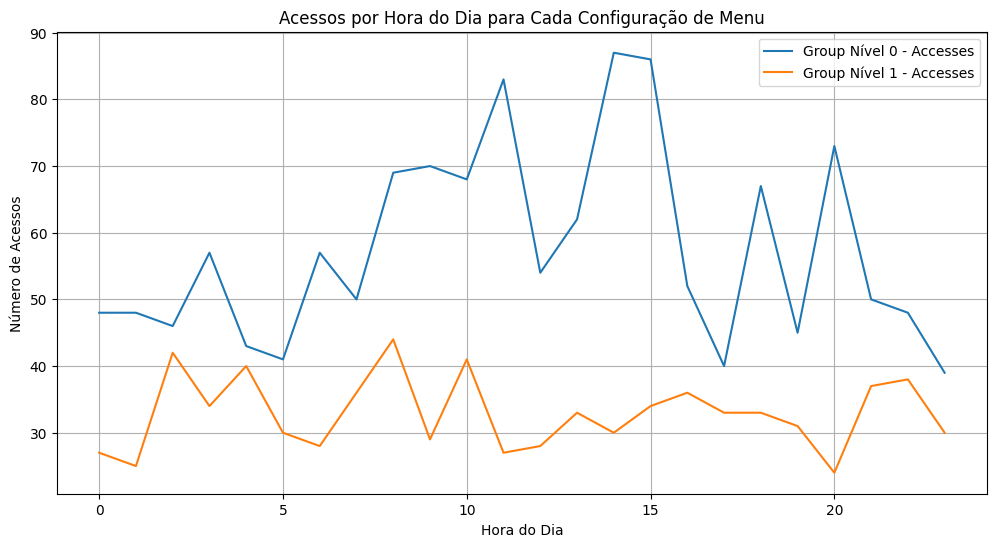

In [57]:
# plotando os acessos ao longo do dia
plt.figure(figsize=(12, 6))
for grp in q6['group'].unique():
    grp_data = q6[q6['group'] == grp]
    plt.plot(grp_data['hour'], grp_data['access_count'], label=f'Group {grp} - Accesses')

plt.title('Acessos por Hora do Dia para Cada Configuração de Menu')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Acessos')
plt.legend()
plt.grid(True)
plt.show()

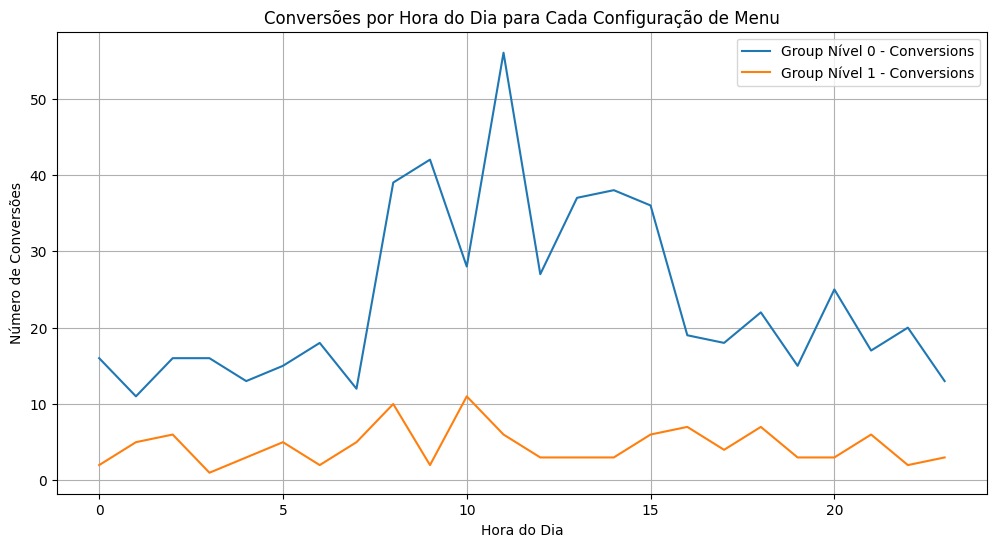

In [58]:
# plotando as conversões ao longo do dia
plt.figure(figsize=(12, 6))
for grp in q6['group'].unique():
    grp_data = q6[q6['group'] == grp]
    plt.plot(grp_data['hour'], grp_data['conversions_count'], label=f'Group {grp} - Conversions')

plt.title('Conversões por Hora do Dia para Cada Configuração de Menu')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Conversões')
plt.legend()
plt.grid(True)
plt.show()

### Questão 6 - Resposta:

##### 6. Existe alguma tendência temporal (comportamento ao longo dia) nos acessos ou conversões para cada configuração do menu?

Acessos:

* O Grupo Nível 0 apresenta variações significativas nos acessos ao longo do dia, com picos em horários específicos (8h, 12h, 15h).


* O Grupo Nível 1 tem acessos mais estáveis, com um aumento gradual até as 5h e uma leve queda após as 15h.

Conversões:

* O Grupo Nível 0 também mostra variações significativas nas conversões, com picos notáveis em horários específicos (11h, 12h).


* O Grupo Nível 1 mantém uma taxa de conversão estável e relativamente baixa durante todo o dia.


### Questão 7 - Resposta:

##### 7. Quais recomendações você faria com base nos dados analisados para otimizar a navegação do site?

Recomendação 1: Focar nos horários de pico elaborando promoções personalizadas e notificações incentivando a conversão dos usuários. 

Recomendação 2: Testagem A/B durante os horários de pico para experimentar diferentes layoutes e funções do Menu Nível 0, que resulta em melhores taxas de conversão.

Recomendação 3: Implementar outras análises do comportamento dos usuários no site com o intuito de entender as páginas mais acessadas e produtos e serviços mais visualizados.